## ⚙️ Import Libraries

In [ ]:
from typing import Annotated   #connect to drive folder
from google.colab import drive

drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/homework_2

Mounted at /gdrive
/gdrive/My Drive/homework_2


In [1]:
#IMPORT LIBRARIES

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load the Data

In [2]:
data = np.load("/kaggle/input/sumarteee/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

x_test_ev = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {x_test_ev.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [3]:
category_map = {0: 0, # background
           1: 1,  # soil
           2: 2,  # bedrock
           3: 3,  # sand
           4: 4  # big rock
}

In [4]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [5]:
def display_color_mapped_image_continuous(image, n_colors=5):
    """
    Display an image with colors mapped from a given image array using a continuous colormap.
    The image array should contain integer values from 0 to n_colors-1, where each integer
    represents a different color sampled linearly from the colormap.

    Args:
    image (ndarray): An array of shape (H, W) containing integer values from 0 to n_colors-1.
    n_colors (int): The number of colors to use from the colormap. Max 5.
    """
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_colors))

    # Map the colors
    colored_image = colors[image.astype(int)]

    return colored_image

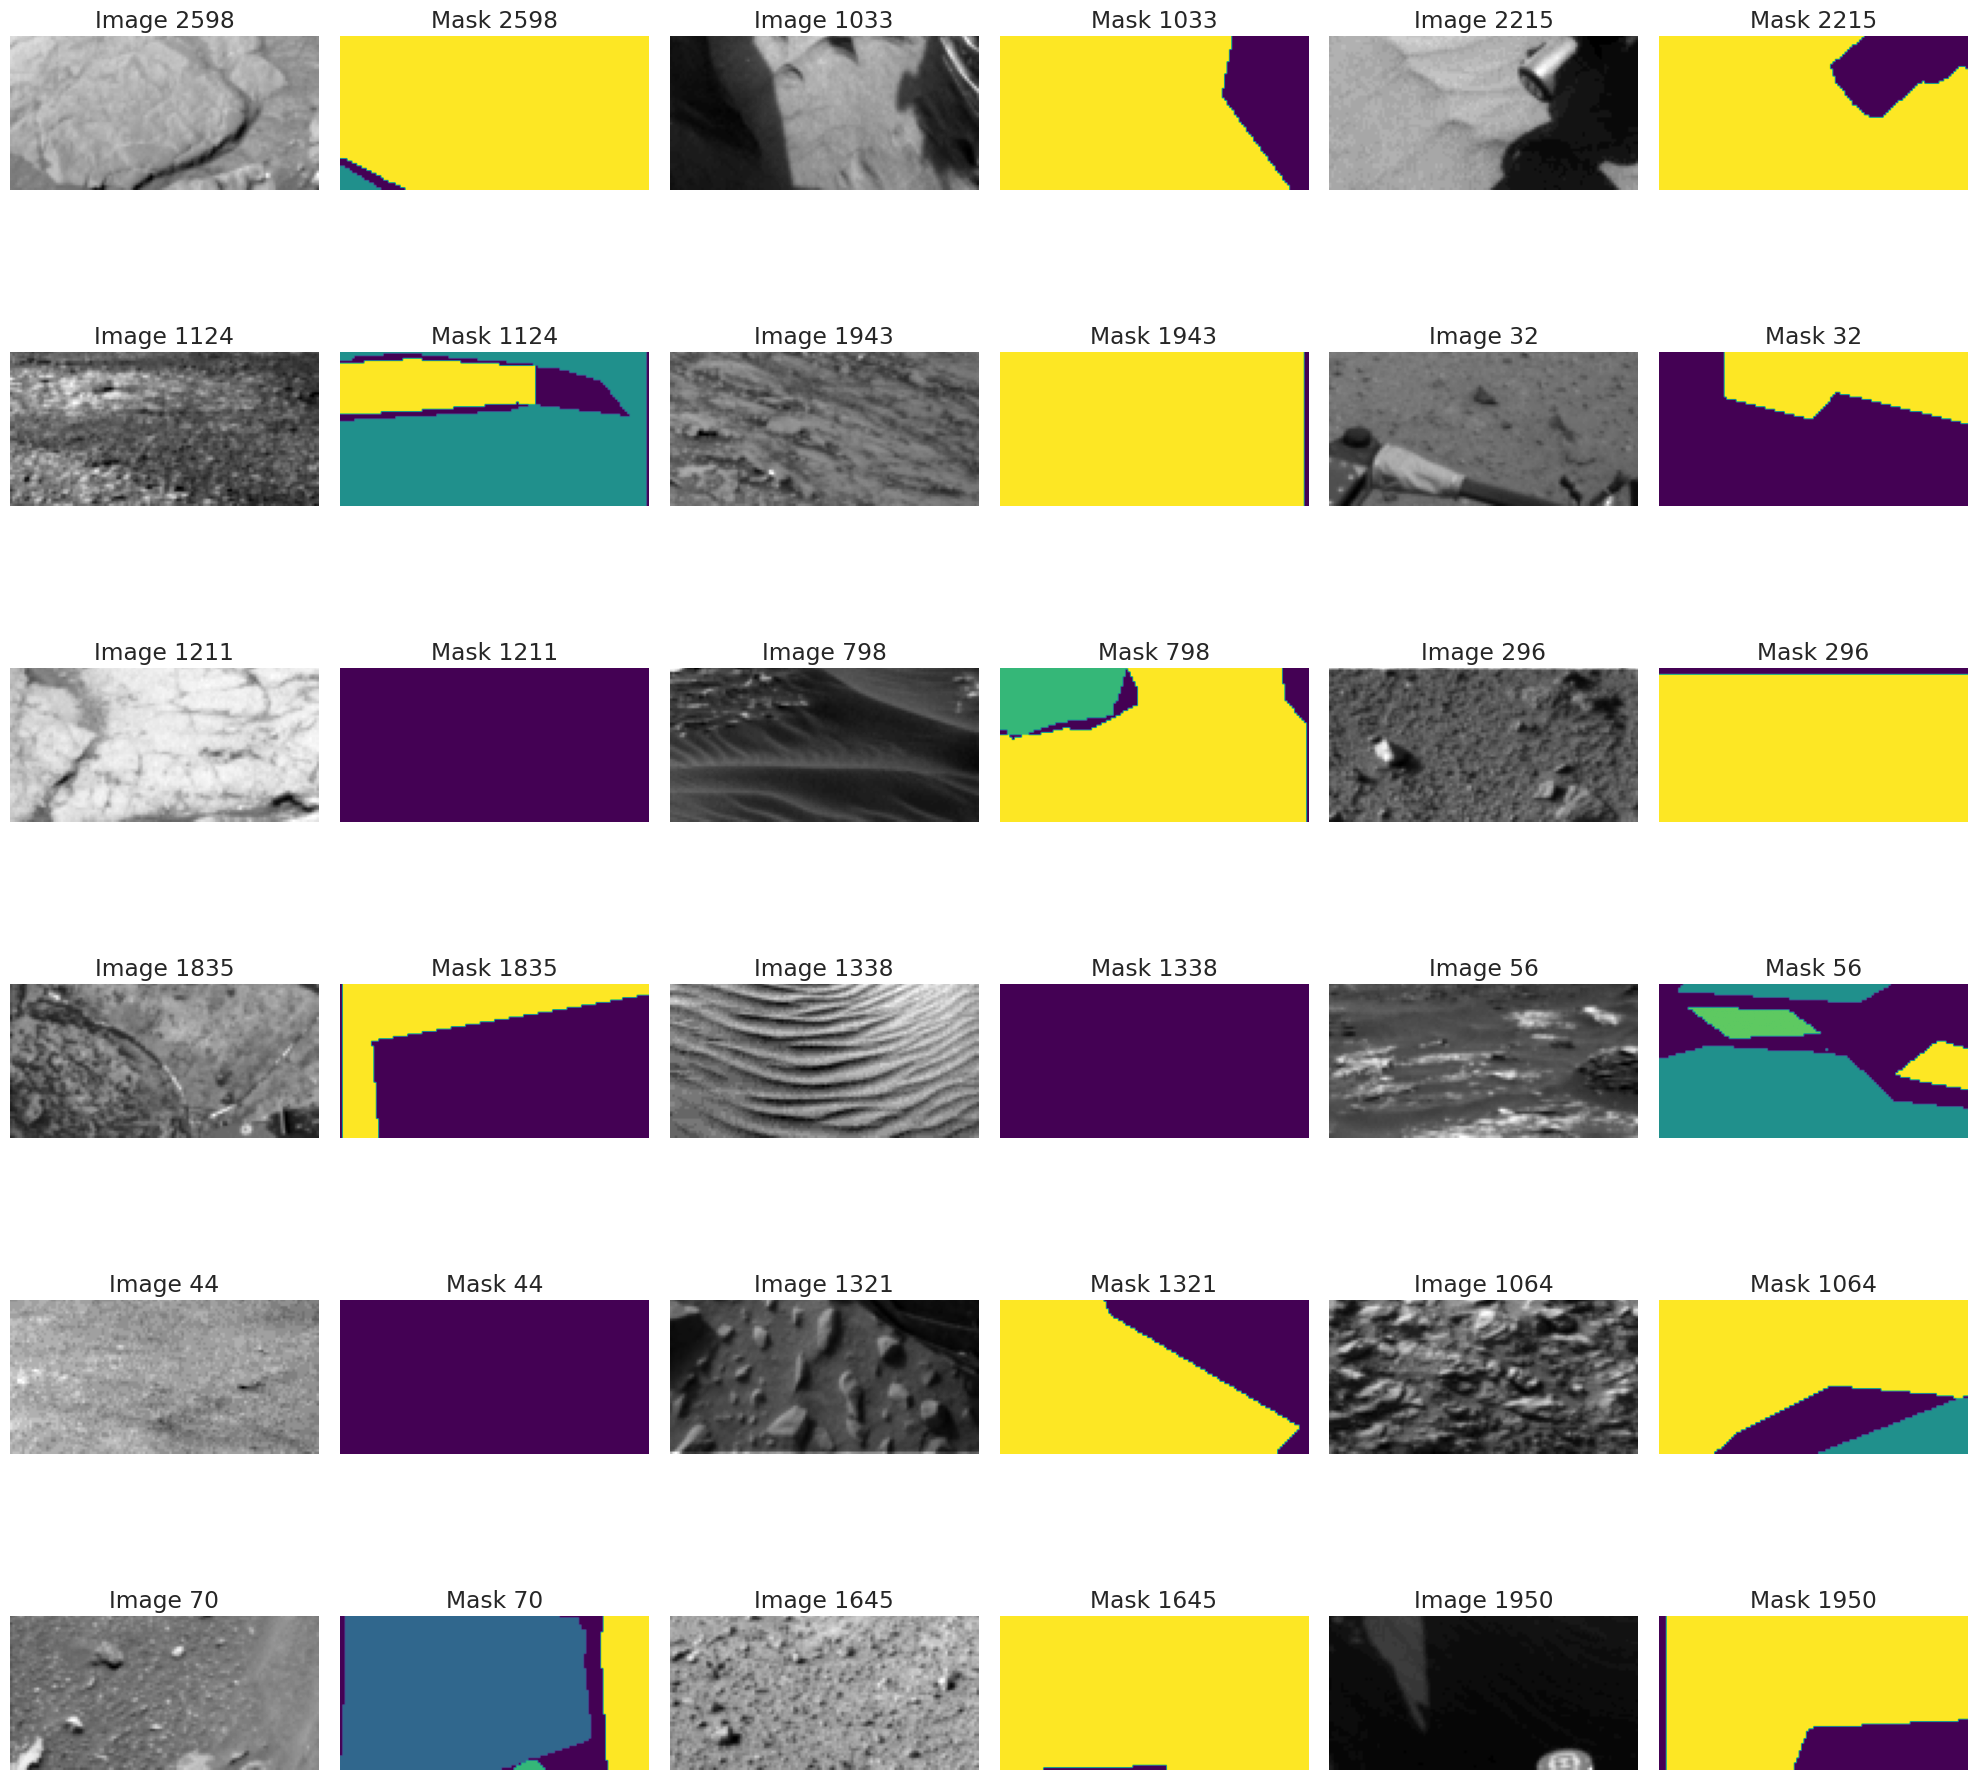

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot random images and their masks
def plot_random_images_with_masks(X_train, y_train, num_pairs=18):
    # Randomly select indices for the images and masks
    indices = np.random.choice(len(X_train), size=num_pairs, replace=False)

    # Create a grid layout for displaying images and masks
    plt.figure(figsize=(20, 20))  # Adjust size for better visibility

    for i, idx in enumerate(indices):
        # Display the grayscale Mars terrain image
        plt.subplot(6, 6, 2 * i + 1)  # Odd columns for images
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Display the segmentation mask
        plt.subplot(6, 6, 2 * i + 2)  # Even columns for masks
        plt.imshow(y_train[idx], cmap='viridis')  # Use a colormap to distinguish classes
        plt.title(f"Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot 25 random pairs of images and masks
plot_random_images_with_masks(X_train, y_train, num_pairs=18)

In [7]:
# Index of the type of image to remove
ET_index= 1082
ET_mask = y_train[ET_index]
count = 0

# Searching of the outsider
ET_to_remove = []

for i in range(len(y_train)):
    if np.array_equal(y_train[i], ET_mask):
        ET_to_remove.append(i)
        count = count+1


# Remove Alien
X= np.delete(X_train, ET_to_remove, axis=0)
y= np.delete(y_train, ET_to_remove, axis=0)
count

110

In [8]:
# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)



# Display the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2254, 64, 128), (2254, 64, 128), (251, 64, 128), (251, 64, 128))

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0


X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 10 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Print the results
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 1883 images (at least 8 pixels)
Class 1: present in 1132 images (at least 8 pixels)
Class 2: present in 1045 images (at least 8 pixels)
Class 3: present in 765 images (at least 8 pixels)
Class 4: present in 53 images (at least 8 pixels)


In [11]:
# Identifica gli indici delle maschere che contengono almeno 10 pixel della classe 4
class_4_indices = [i for i, label in enumerate(y_train) if tf.reduce_sum(tf.cast(label == 4, tf.int32)) >= 8]

# Estrai le immagini e le maschere associate alla classe 4
X_class_4 = X_train[class_4_indices]
y_class_4 = y_train[class_4_indices]

print(f"Campioni con classe 4: {len(X_class_4)}")


Campioni con classe 4: 53


In [12]:
from tensorflow.keras.layers import RandomFlip

def augment_image4(image, label):
    # Aggiunge una dimensione canale se necessario
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)

    # Concatena immagine e label lungo il canale
    combined = tf.concat([image, label], axis=-1)  # Shape: (H, W, 2)

    # Flip casuale
    random_flip = RandomFlip(mode="horizontal")
    combined = random_flip(combined)

    # Divide immagine e label
    image = combined[..., 0:1]  # Primo canale
    label = combined[..., 1:2]  # Secondo canale

    # Rimuove dimensione canale se aggiunta
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label



In [13]:
def augment_class_4(X_class_4, y_class_4, target_factor=20):
    """
    Augment samples of class 4 using horizontal flip until their number is increased by the target_factor.
    """
    augmented_X = []
    augmented_y = []

    num_original = len(X_class_4)
    total_target = num_original * target_factor

    # Calculate how many augmentations are needed
    current_total = num_original
    while current_total < total_target:
        for i in range(len(X_class_4)):
            # Applica solo il flip orizzontale usando la funzione aggiornata
            img, mask = augment_image4(X_class_4[i], y_class_4[i])
            augmented_X.append(img)
            augmented_y.append(mask)
            current_total += 1
            if current_total >= total_target:
                break

    # Convert to NumPy arrays
    augmented_X = tf.stack(augmented_X).numpy()
    augmented_y = tf.stack(augmented_y).numpy()

    return augmented_X, augmented_y

# Applica il sovracampionamento e l'augmentation per la classe 4
augmented_X_class_4, augmented_y_class_4 = augment_class_4(X_class_4, y_class_4, target_factor=20)



In [14]:
# Concatenate the new samples with the training set
X_train = np.concatenate([X_train, augmented_X_class_4[..., np.newaxis]], axis=0) # Add a new axis to augmented_X_class_4
y_train = np.concatenate([y_train, augmented_y_class_4], axis=0)

print(f"New number of samples in the training set: {X_train.shape[0]}")

New number of samples in the training set: 3261


In [15]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 10 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Print the results
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 2890 images (at least 8 pixels)
Class 1: present in 1474 images (at least 8 pixels)
Class 2: present in 1748 images (at least 8 pixels)
Class 3: present in 1468 images (at least 8 pixels)
Class 4: present in 1060 images (at least 8 pixels)


In [16]:
# Set batch size for training
batch_size = 128

# Set learning rate for the optimiser
learning_rate = 4e-4

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 200


In [17]:
# Definizione di se_block (aggiungi questa funzione prima di usare SENet blocks)
def se_block(input_tensor, name, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze')(input_tensor)
    se = tfkl.Dense(channels // reduction_ratio, activation='relu', name=f'{name}_reduce')(se)
    se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_expand')(se)
    se = tfkl.Reshape((1, 1, channels), name=f'{name}_reshape')(se)
    se = tfkl.Multiply(name=f'{name}_scale')([input_tensor, se])
    return se

def senet_block(input_tensor, filters, kernel_size=3, padding='same', stack=1, name='SE_block'):
    """
    SENet block: Combina convoluzioni e SE block.
    Args:
        input_tensor: Input tensor
        filters: Number of filters for convolution
        kernel_size: Kernel size for convolution
        padding: Padding mode
        stack: Number of convolutional layers in the block
        name: Name of the block
    Returns:
        Output tensor after applying convolutions and SE block
    """
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv{i+1}')(x)
        x = tfkl.GroupNormalization(name=f'{name}_bn{i+1}')(x)
        x = tfkl.ReLU(name=f'{name}_relu{i+1}')(x)

    # Add SE block
    x = se_block(x, name=f'{name}_se')

    return x

from tensorflow.keras.regularizers import l2
def attention_gate(x, g, inter_channels, name):
    """
    Implementazione di un Attention Gate.
    Args:
        x: Tensor dallo skip connection (bassa risoluzione).
        g: Tensor del percorso principale (alta risoluzione).
        inter_channels: Numero di canali intermedi.
        name: Nome del layer.
    Returns:
        Tensor con applicazione dell'Attention Gate.
    """
    theta_x = tfkl.Conv2D(inter_channels, 1, use_bias=False, name=f'{name}_theta_x')(x)
    phi_g = tfkl.Conv2D(inter_channels, 1, use_bias=False, name=f'{name}_phi_g')(g)
    add = tfkl.Add(name=f'{name}_add')([theta_x, phi_g])
    relu = tfkl.Activation('relu', name=f'{name}_relu')(add)
    psi = tfkl.Conv2D(1, 1, activation='sigmoid', name=f'{name}_psi')(relu)
    return tfkl.Multiply(name=f'{name}_attention_mul')([x, psi])

def residual_bottleneck(input_tensor, filters, name):
    x = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu', name=f'{name}_conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=f'{name}_bn1')(x)
    x = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu', name=f'{name}_conv2')(x)
    x = tfkl.BatchNormalization(name=f'{name}_bn2')(x)

    # Residual connection
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same', activation='relu', name=f'{name}_shortcut')(input_tensor)
    shortcut = tfkl.BatchNormalization(name=f'{name}_shortcut_bn')(shortcut)

    x = tfkl.Add(name=f'{name}_add')([x, shortcut])
    x = tfkl.ReLU(name=f'{name}_relu')(x)
    return x



In [18]:
def get_seunet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder with SENet Blocks
    down_block_1 = senet_block(input_layer, filters=32, name='down_block1_')
    down_block_1 = tfkl.Dropout(0.1, name='dropout1')(down_block_1)  # Added dropout
    d1 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool1')(down_block_1)

    down_block_2 = senet_block(d1, filters=64, name='down_block2_')
    down_block_2 = tfkl.Dropout(0.1, name='dropout2')(down_block_2)  # Added dropout
    d2 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool2')(down_block_2)

    down_block_3 = senet_block(d2, filters=128, name='down_block3_')
    down_block_3 = tfkl.Dropout(0.1, name='dropout3')(down_block_3)  # Added dropout
    d3 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool3')(down_block_3)

    # Bottleneck
    bottleneck = senet_block(d3, filters=256, name='bottleneck')
    bottleneck = tfkl.Dropout(0.1, name='bottleneck_dropout')(bottleneck)  # Added dropout
    # Decoder with Attention Gates
    # MODIFICATION: use Conv2DTranspose for upsampling
    u1 = tfkl.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='up1')(bottleneck)
    att1 = attention_gate(down_block_3, u1, inter_channels=128, name='att1')
    # FIX: Adjust the number of filters to match u1's channel dimension (128)
    u1 = tfkl.Conv2D(128, (1, 1), activation='relu', padding='same', name='u1_reshape')(u1)
    u1 = tfkl.Add(name='add1')([u1, att1])
    u1 = senet_block(u1, filters=128, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='up2')(u1)  # Modified
    att2 = attention_gate(down_block_2, u2, inter_channels=64, name='att2')
    u2 = tfkl.Add(name='add2')([u2, att2])
    u2 = senet_block(u2, filters=64, name='up_block2_')

    u3 = tfkl.UpSampling2D(size=(2, 2), name='up3')(u2)
    att3 = attention_gate(down_block_1, u3, inter_channels=32, name='att3')
    # MODIFICATION: Adjust u3's channels to match att3
    u3 = tfkl.Conv2D(32, (1, 1), activation='relu', padding='same', name='u3_reshape')(u3)
    u3 = tfkl.Add(name='add3')([u3, att3])
    u3 = senet_block(u3, filters=32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='SEEA-UNet')
    return model


Model: "SEEA-UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__con… │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__bn1  │ (None, 64, 128, │        64 │ down_block1__… │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__rel… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (ReLU)            │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__se_… │ (None, 32)      │         0 │ down_block1__… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__se_… │ (None, 2)       │        66 │ down_block1__… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__se_… │ (None, 32)      │        96 │ down_block1__… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__se_… │ (None, 1, 1,    │         0 │ down_block1__… │   -   │
│ (Reshape)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__se_… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Multiply)        │ 32)             │           │ down_block1__… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout1          │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 32, 64,  │         0 │ dropout1[0][0] │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__con… │ (None, 32, 64,  │    18,496 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__bn1  │ (None, 32, 64,  │       128 │ down_block2__… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__rel… │ (None, 32, 64,  │         0 │ down_block2__… │   -   │
│ (ReLU)            │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__se_… │ (None, 64)      │         0 │ down_block2__… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__se_… │ (None, 4)       │       260 │ down_block2__… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2__se_… │ (None, 64)      │       320 │ down_block2__… │   Y 

 Total params: 1,029,172 (3.93 MB)

 Trainable params: 1,029,172 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

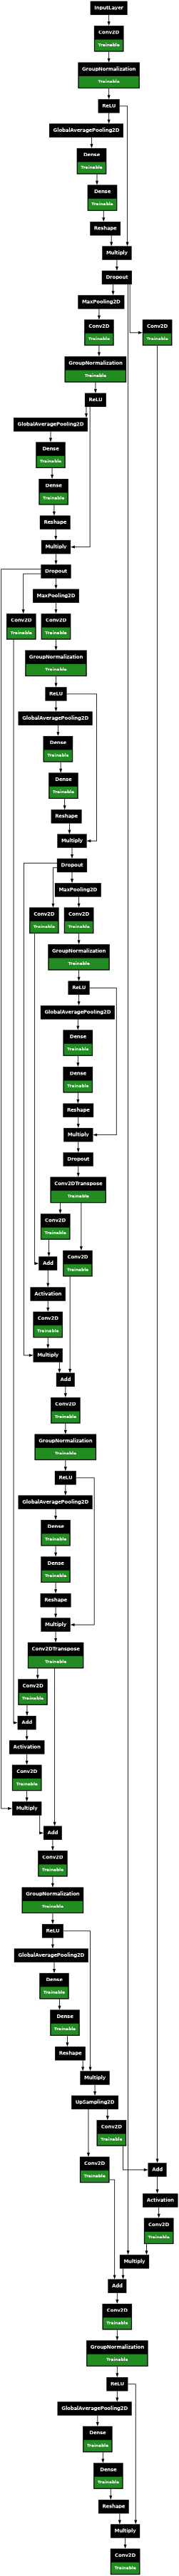

In [19]:
model = get_seunet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=30)

## 🛠️ Train and Save the Model

In [20]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [22]:
import tensorflow.keras.backend as K

def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes."""
    backend = kwargs.get('backend', K)
    x = backend.permute_dimensions(x, (3, 0, 1, 2))
    x = backend.gather(x, indexes)
    x = backend.permute_dimensions(x, (1, 2, 3, 0))
    return x

def stable_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.75):
    """Numerically stable focal loss for multi-class segmentation, ignoring class 0."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Controlla se y_true è one-hot encoded, altrimenti lo converte
    if len(y_true.shape) < len(y_pred.shape):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

    # Escludi la classe 0 selezionando i canali 1-4 (indice 1 fino alla fine)
    class_indexes = tf.range(1, 5)  # Indici da 1 a num_classi-1
    y_true = _gather_channels(y_true, indexes=class_indexes, backend=K)
    y_pred = _gather_channels(y_pred, indexes=class_indexes, backend=K)

    # Clipping per evitare instabilità numerica
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # Calcolo della Focal Loss
    loss = -y_true * (alpha * K.pow(1.0 - y_pred, gamma) * K.log(y_pred))

    return K.mean(loss)


def dice_loss_class_4(y_true, y_pred, smooth=1):
    """
    Dice loss for class 4 only, with one-hot encoding verification.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Controlla se y_true è one-hot encoded, altrimenti lo converte
    if len(y_true.shape) < len(y_pred.shape):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

    # Isola la classe 4
    y_true_class_4 = y_true[..., 4]  # Assume che la classe 4 sia all'indice 4
    y_pred_class_4 = y_pred[..., 4]  # Assume che l'output sia un tensor con ultima dimensione come classi

    # Calcolo della Dice Loss per la classe 4
    intersection = tf.reduce_sum(y_true_class_4 * y_pred_class_4)
    union = tf.reduce_sum(y_true_class_4) + tf.reduce_sum(y_pred_class_4)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    # Return the calculated Dice loss
    return 1 - dice # Return 1-dice for loss calculation



def combined_loss(y_true, y_pred, focal_weight=0.8, dice_weight=0.2):
    """
    Combined loss of stable focal loss and dice loss for class 4.
    """
    focal = stable_focal_loss(y_true, y_pred)
    dice = dice_loss_class_4(y_true, y_pred)
    return focal_weight * focal + dice_weight * dice

Epoch 1/200


I0000 00:00:1734209999.127821      94 service.cc:145] XLA service 0x7d19000024a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734209999.127870      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734209999.127875      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734210030.087269      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 - 84s - 3s/step - accuracy: 0.3031 - loss: 0.1139 - mean_iou: 0.1454 - val_accuracy: 0.3795 - val_loss: 0.1141 - val_mean_iou: 0.1625 - learning_rate: 4.0000e-04
Epoch 2/200
26/26 - 5s - 187ms/step - accuracy: 0.3461 - loss: 0.0950 - mean_iou: 0.1938 - val_accuracy: 0.4122 - val_loss: 0.0999 - val_mean_iou: 0.1909 - learning_rate: 4.0000e-04
Epoch 3/200
26/26 - 5s - 188ms/step - accuracy: 0.3811 - loss: 0.0837 - mean_iou: 0.2397 - val_accuracy: 0.4360 - val_loss: 0.0894 - val_mean_iou: 0.2158 - learning_rate: 4.0000e-04
Epoch 4/200
26/26 - 5s - 191ms/step - accuracy: 0.4105 - loss: 0.0752 - mean_iou: 0.2838 - val_accuracy: 0.4568 - val_loss: 0.0813 - val_mean_iou: 0.2395 - learning_rate: 4.0000e-04
Epoch 5/200
26/26 - 5s - 192ms/step - accuracy: 0.4357 - loss: 0.0690 - mean_iou: 0.3226 - val_accuracy: 0.4565 - val_loss: 0.0782 - val_mean_iou: 0.2314 - learning_rate: 4.0000e-04
Epoch 6/200
26/26 - 5s - 194ms/step - accuracy: 0.4444 - loss: 0.0651 - mean_iou: 0.3388 - val_accuracy:

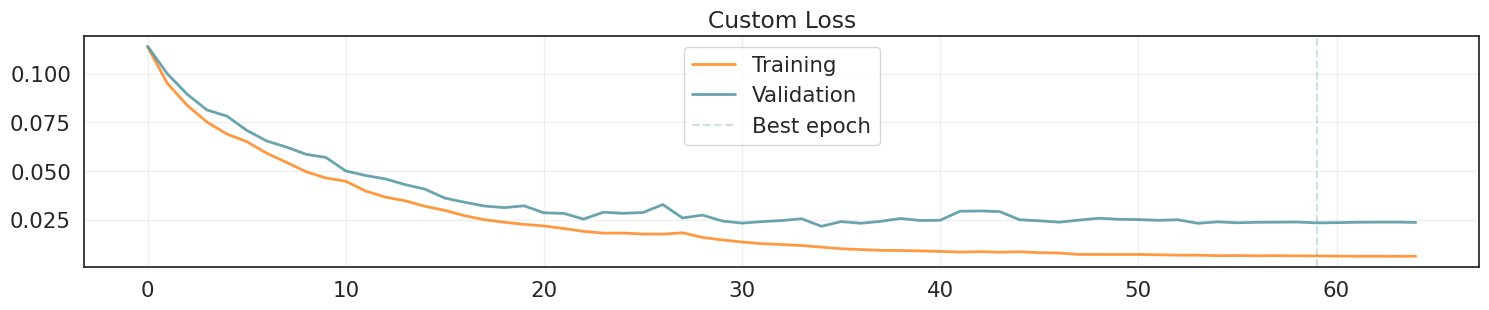

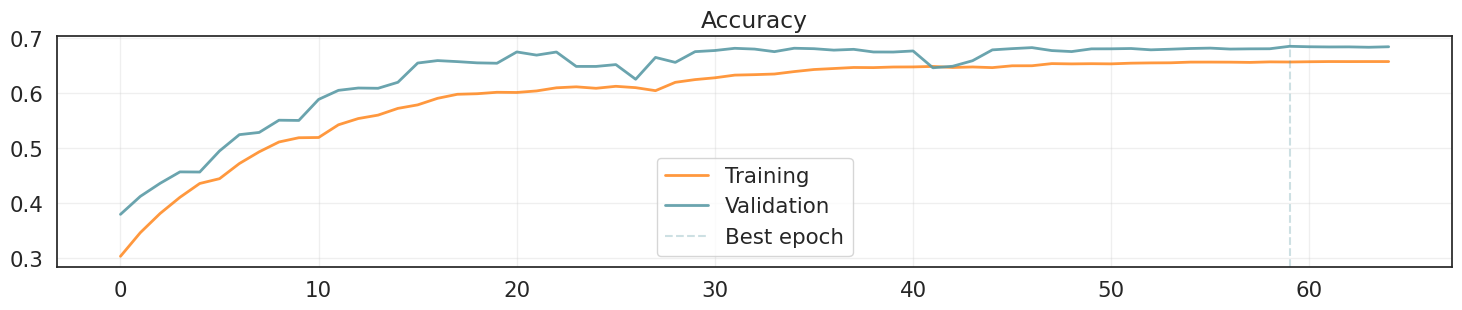

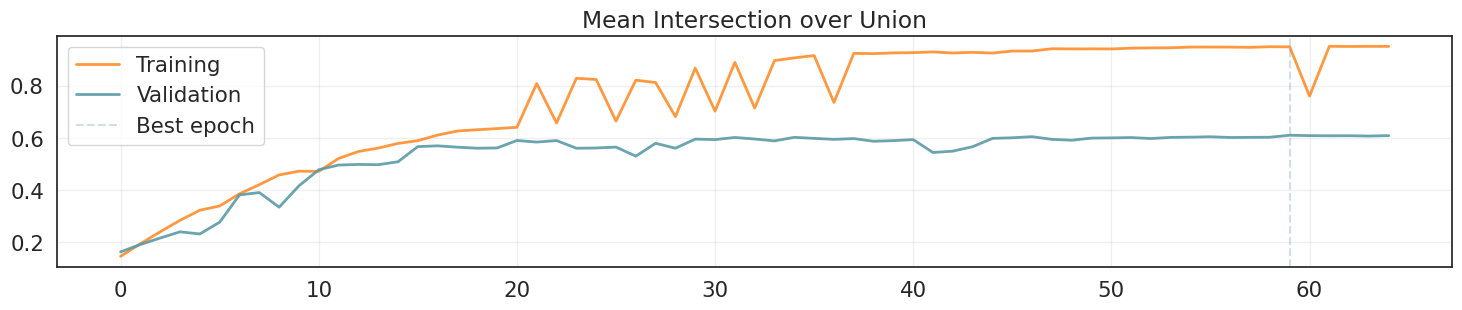

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=4e-4),
    loss=stable_focal_loss,
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

# Addestramento
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)
]

history = model.fit(
    x=X_train*255.0,
    y=y_train,
    validation_data=(X_val*255.0, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)


best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Custom Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(f"X_test shape: {test_set.shape}")
print(f"y_test shape: {y_test.shape}")

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_set*255.0, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

X_test shape: (226, 64, 128, 1)
y_test shape: (226, 64, 128)
Test Accuracy: 0.6496
Test Mean Intersection over Union: 0.553


In [24]:
model_filename = "model_silvia.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_silvia.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [25]:
x_test_ev = x_test_ev[..., np.newaxis]

In [26]:
preds = model.predict(x_test_ev)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Predictions shape: (10022, 64, 128)


In [27]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)




#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```